In [42]:
import bioframe as bf
import pandas as pd
import copy
import numpy as np
from schema import DFSchema
from df_loader import CrisprDFLoader, PredDFLoader
from overlaps import (
    read_overlaps_from_file, merge_multiple_predictions, compute_crispr_overlaps
)
# pd.set_option('display.max_rows', 1000) 

In [43]:
CRISPR_FILENAME = "/oak/stanford/groups/engreitz/Projects/Benchmarking/CRISPR_data/EPCrisprBenchmark_ensemble_data_GRCh38.tsv.gz"
# PRED_FILENAME = "/oak/stanford/groups/engreitz/Users/atan5133/abc_run_comparisons/results_no_qnorm_08_28_dev/Predictions/EnhancerPredictionsAllPutative.tsv.gz"
PRED_FILENAME = '/oak/stanford/groups/engreitz/Users/atan5133/abc_run_comparisons/results_10_26_dev_atac_k562_hic/Predictions/EnhancerPredictionsAllPutative.tsv.gz'
OVERLAP_FILENAME = "crispr_pred_overlaps_noqnorm.csv"
ABC_THRESHOLD = 0.026
TSS_REF_FILE = "resources/genome_annotations/RefSeqCurated.170308.bed.CollapsedGeneBounds.hg38.TSS500bp.bed"
TARGET_GENE = "MYC"

In [44]:
pred_df = PredDFLoader(PRED_FILENAME, TSS_REF_FILE, ABC_THRESHOLD).load()
crispr_df = CrisprDFLoader(CRISPR_FILENAME, TSS_REF_FILE).load()
overlap_df = compute_crispr_overlaps(
    crispr_df, pred_df
)
# overlap_df = read_overlaps_from_file(OVERLAP_FILENAME)

/oak/stanford/groups/engreitz/Users/atan5133/.conda/envs/error_analysis/lib/python3.9/site-packages/bioframe/core/specs.py:150: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  pd.api.types.is_categorical_dtype(chrom_dtype),
/oak/stanford/groups/engreitz/Users/atan5133/.conda/envs/error_analysis/lib/python3.9/site-packages/bioframe/core/specs.py:150: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  pd.api.types.is_categorical_dtype(chrom_dtype),
/oak/stanford/groups/engreitz/Users/atan5133/.conda/envs/error_analysis/lib/python3.9/site-packages/bioframe/ops.py:514: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_input_2[overlap_df_idxs[:, 1] =

In [45]:
df = merge_multiple_predictions(overlap_df, ABC_THRESHOLD)

In [46]:
def format_distance(bp):
    kb = bp / 1000
    mb = kb / 1000

    if mb >= 1:
        return f"{mb:.2f} Mbp"
    elif kb >= 1:
        return f"{kb:.2f} Kbp"
    else:
        return f"{bp} bp"

In [47]:
gene_df = df[df["TargetGene_crispr"] == TARGET_GENE]
# pretty print distance
gene_df.loc[:,'distance_pred'] = gene_df['distance_pred'].apply(format_distance)

In [48]:
# Sorted by top 10 contact
gene_df_sorted = gene_df.sort_values(by="hic_contact_pl_scaled_adj_pred", ascending=False)
columns_pred = ['name', 'distance', 'activity_base', 'hic_contact', 'hic_contact_pl_scaled_adj', 'ABC.Score', 'IsSignificant', 'ABC.Score.Numerator', 'normalized_dhs', 'isSelfPromoter', 'powerlaw_contact', 'powerlaw_contact_reference','hic_contact_pl_scaled']
columns = ["dataset_crispr", "EffectSize_crispr", "IsSignificant_crispr"] + [col+'_pred' for col in columns_pred]
gene_df_sorted[:10][columns]

KeyError: "['normalized_dhs_pred'] not in index"

In [ ]:
"""
Analysis:
Highest contact isn't good as a metric by itself because you tend to see close (<10kb) very weak enhancers. 
Suprisingly, contact is still very high from large distances. 162Kbp is the 3rd most contacted with the gene
But not all far enhancers with contact are strong enhancers. 

Questions:
- how is activity bse calculated? normalized dhs?
- I wonder where the CTCF sites are here?
"""

In [ ]:
# top 15 effect sizes
"""
Analysis:
Seems like we 
"""
gene_df.sort_values(by="EffectSize_crispr", ascending=True)[columns][:15]

In [ ]:
"""
Analysis:
It looks like all of the enhancers for this gene are distant enhancers. Only 2/8 of the significant 
enhancers are in the top 10 for contact. 

Looking at the misses we get from this data, I wonder if normalizing the score across all E-G candidates makes
sense. You end up penalizing many enhancers from being considered strong because it's 'saturated'.

It may make more sense to normalize activity and contact by themselves, without normalization afterwards.
The normalization should be similar to RNA normalization, with RPM/TPM. This may scale better to different
cell types, as we can just look at the activity RPM and contact.

"""

In [ ]:
# Total Significant enhancers: 9
print(len(gene_df[gene_df["IsSignificant_crispr"]]))

# Total predicted signficant enhancers: 3
print(len(gene_df[gene_df["IsSignificant_pred"]]))

In [ ]:
crispr_df[crispr_df["TargetGene"] == "MYC"].iloc[0]

In [ ]:
gene_df.iloc[0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


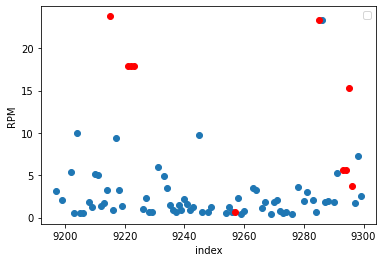

In [49]:
import matplotlib.pyplot as plt
plt.clf()
X, Y = [], []
put_X, put_Y = [], []
for idx, row in gene_df.iterrows():
    activity = row['activity_base_pred']
    if row['IsSignificant_crispr']:
        put_X.append(idx)
        put_Y.append(activity)
    else:
        X.append(idx)
        Y.append(activity)

plt.scatter(X,Y)
plt.scatter(put_X,put_Y, color='red')
plt.xlabel('index')
plt.ylabel('RPM')
plt.legend()
plt.show()